# The Effects of the EPG and the EBSS on consumer welfare - an application of Ramsey Pricing

In [2]:
# Neccessary Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## The Consumer

We assume two consumers: High Income (HI) and Low Income (LI).

Demand function for High Income Consumers:

$$q_{HI} = A - B * p_{HI}$$

Demand function for Low Income Consumers:

$$q_{LI} = C - D * p_{LI}$$

These equations represent the basic linear demand relationship where $q$ is the quantity demanded in MWh, and $p$ is the price in £/MWh.

Next we select four different parameters: `A`, `B`, `C` and `D`

In general, the intercepts (`A` and `C`) tell us about the baseline consumption levels without the influence of price, reflecting factors like needs, preferences, and possibly non-price related socio-economic factors.

The slopes (`B` and `D`), on the other hand, provide insight into how responsive each group is to price changes, indicating their price elasticity of demand.

These parameters have been chosen in line with the evidence already laid out.

In [223]:
# Define the parameters for the demand functions of High Income (HI) and Low Income (LI) groups
# Demand function for HI: q_HI = A - B * p_HI
# Demand function for LI: q_LI = C - D * p_LI
# A, B, C, D = 0.014, 0.000714, 0.008, 0.000437  # A, B for HI and C, D for LI
# Test (assuming both high and low income consumers have the same consumption when price = 0)
A, B, C, D = 0.08, 0.000714, 0.08, 0.000437  # A, B for HI and C, D for LI

# Elasticities
epsilon_HI, epsilon_LI = -0.714, -0.437 

## The Firm

Now we need to specify parameters relevant to the firm. Specifically, the firm faces 3 key constraints:

1)  The Capacity Constraint;
2)  The Break-Even Constraint;
3)  The Demand Constraint;

We can define the parameters as follows:

In [224]:
# Fixed costs that the energy provider needs to cover
# 27 million house holds and 60% of that, with a standing charge of £0.83 per day
fixed_costs = 27000000*0.83*0.6 # Daily fixed costs in £

# Capacity constraint (maximum energy supply per day) and daily break-even revenue
capacity_constraint = 1000000000000  # MWh per day: They can make as much as they want ?
# break_even_revenue = fixed_costs +   # Daily revenue needed to break even

# Marginal cost of supplying energy in £/MWh
MC = 67 # Yearly average across the last 10 years


## The Uniform Pricing Scenario



In [225]:
# Uniform pricing scenario: A single price for both groups
# Define functions for total demand and revenue with a uniform price
def total_demand_uniform_price(price):
    demand_HI = (A - B * price)
    demand_LI = (C - D * price) 
    total_economy_demand_HI = demand_HI * 27000000 * 0.3
    total_economy_demand_LI = demand_LI * 27000000 * 0.3
    total_demand = total_economy_demand_HI + total_economy_demand_LI
    return min(total_demand, capacity_constraint)  # Ensure demand does not exceed capacity

def total_revenue_uniform_price(price):
    return price * total_demand_uniform_price(price)

# Define a function for the break-even constraint under uniform pricing
def break_even_uniform_price_constraint(price):
    demand_HI = (A - B * price)
    demand_LI = (C - D * price) 
    total_economy_demand_HI = demand_HI * 27000000 * 0.3
    total_economy_demand_LI = demand_LI * 27000000 * 0.3
    total_demand = total_economy_demand_HI + total_economy_demand_LI
    break_even_revenue = (MC * total_demand) + fixed_costs
    return total_revenue_uniform_price(price) - break_even_revenue

# Solve for the uniform price that meets the break-even requirement
uniform_price_initial_guess = 67
from scipy.optimize import least_squares
uniform_price_solution = fsolve(break_even_uniform_price_constraint, uniform_price_initial_guess)[0]

/var/folders/40/kg80nfhj1bj8q3887gqsfbf40000gq/T/ipykernel_63589/3144218233.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  uniform_price_solution = fsolve(break_even_uniform_price_constraint, uniform_price_initial_guess)[0]


The optimal price under uniform pricing can then be given as:

In [226]:
round(uniform_price_solution, ndigits=2)

103.0

In [227]:
# Quantities
print((A - B * uniform_price_solution))
print((C - D * uniform_price_solution))


0.006456529860399088
0.034988100208675633


In [228]:
# Function to calculate consumer surplus: CS = 0.5 * base * height
def calculate_consumer_surplus(a, b, price):
    base = a - b * price  # base of the demand triangle
    height = a / b - price  # height of the demand triangle
    return 0.5 * base * height  # Area representing consumer surplus

# Consumer surplus for HI and LI under uniform pricing
cs_HI_uniform = calculate_consumer_surplus(A, B, uniform_price_solution)
cs_LI_uniform = calculate_consumer_surplus(C, D, uniform_price_solution)


In [229]:
print(f"Uniform Price: £{uniform_price_solution:.2f}")
print(f"High Income Consumer Surplus: £{cs_HI_uniform:.2f}")
print(f"Low Income Consumer Surplus: £{cs_LI_uniform:.2f}")

Uniform Price: £103.00
High Income Consumer Surplus: £0.03
Low Income Consumer Surplus: £1.40


Now for applying ramsey pricing

In [230]:
# Define a function to calculate total revenue based on Ramsey pricing
def revenue(k):
    # Prices for HI and LI are calculated using the Ramsey formula
    p_HI = MC / (1 - k / epsilon_HI)
    p_LI = MC / (1 - k / epsilon_LI)

    # Quantities demanded for HI and LI are derived from the demand functions
    q_HI = (A - B * p_HI) * 27000000 * 0.3
    q_LI = (C - D * p_LI) * 27000000 * 0.3
    
    # Total revenue calculation
    return (p_HI * q_HI) + (p_LI * q_LI)

# Define a function for the break-even constraint
def break_even_constraint(k):
    # The revenue must match the break-even revenue for sustainability
    # Prices for HI and LI are calculated using the Ramsey formula
    p_HI = MC / (1 - k / epsilon_HI)
    p_LI = MC / (1 - k / epsilon_LI)

    # Quantities demanded for HI and LI are derived from the demand functions
    q_HI = (A - B * p_HI) * 27000000 * 0.3
    q_LI = (C - D * p_LI) * 27000000 * 0.3

    break_even_revenue = (MC * (q_HI + q_LI)) + fixed_costs
    constraint = revenue(k) - break_even_revenue
    return constraint

# Solve for k using fsolve, with an initial guess
k_initial = 0
#k_solution = fsolve(break_even_constraint, k_initial, xtol=1e-6, maxfev=1000)[0]

# Using least squares instead
from scipy.optimize import least_squares
k_solution = least_squares(break_even_constraint, k_initial).x[0]

# Print the final result
print("Optimal value for k:", k_solution)


Optimal value for k: -0.15952424949458238


In [231]:
# Calculate the prices for HI and LI using the solved value of k
p_HI_solution = MC / (1 - k_solution / epsilon_HI)
p_LI_solution = MC / (1 - k_solution / epsilon_LI)

# Consumer surplus for HI and LI under Ramsey pricing
cs_HI_ramsey = calculate_consumer_surplus(A, B, p_HI_solution)
cs_LI_ramsey = calculate_consumer_surplus(C, D, p_LI_solution)

print(f"Ramsey Price High Income: £{p_HI_solution:.2f}")
print(f"Ramsey Price Low Income: £{p_LI_solution:.2f}")

print(f"High Income Consumer Surplus: £{cs_HI_ramsey:.2f}")
print(f"Low Income Consumer Surplus: £{cs_LI_ramsey:.2f}")

Ramsey Price High Income: £86.28
Ramsey Price Low Income: £105.52
High Income Consumer Surplus: £0.24
Low Income Consumer Surplus: £1.31


In [232]:
# Function to plot both HI and LI demand curves and consumer surpluses on the same graph
# with total consumer surplus annotation
def plot_combined_demand_curves_with_total_cs(a_HI, b_HI, price_HI, a_LI, b_LI, price_LI, title, cs_HI, cs_LI):
    # Generate a range of quantities for HI and LI
    quantities_HI = np.linspace(0, a_HI, 500)
    quantities_LI = np.linspace(0, a_LI, 500)
    
    # Calculate prices for each quantity using the inverse demand function
    prices_HI = (a_HI - quantities_HI) / b_HI
    prices_LI = (a_LI - quantities_LI) / b_LI

    # Calculate total consumer surplus
    total_cs = (cs_HI + cs_LI)
    
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot HI demand curve and consumer surplus
    plt.plot(quantities_HI, prices_HI, label="HI Demand Curve")
    plt.fill_between(quantities_HI, prices_HI, price_HI, where=(quantities_HI <= (a_HI - b_HI * price_HI)), 
                     color='lightblue', alpha=0.5, label=f"HI CS: £{cs_HI:.2f}")

    # Plot LI demand curve and consumer surplus
    plt.plot(quantities_LI, prices_LI, label="LI Demand Curve", color='orange')
    plt.fill_between(quantities_LI, prices_LI, price_LI, where=(quantities_LI <= (a_LI - b_LI * price_LI)), 
                     color='lightgreen', alpha=0.5, label=f"LI CS: £{cs_LI:.2f}")

    # Price lines for HI and LI
    plt.axhline(y=price_HI, color='blue', linestyle='--', label=f"HI Price = £{price_HI:.2f}")
    plt.axhline(y=price_LI, color='green', linestyle='--', label=f"LI Price = £{price_LI:.2f}")

    # Total consumer surplus annotation
    plt.annotate(f"Total CS per day: £{total_cs:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))

    # Labels and title
    plt.xlabel("Quantity Demanded")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

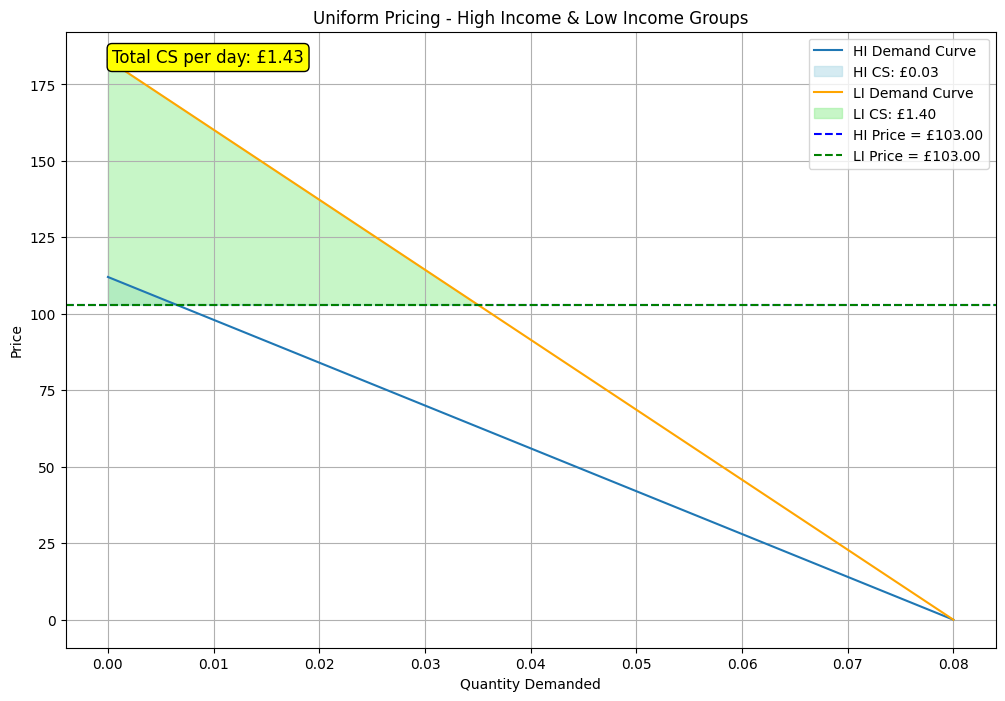

In [233]:
# Plot for both groups under Uniform Pricing with total consumer surplus annotation
plot_combined_demand_curves_with_total_cs(A, B, uniform_price_solution, C, D, uniform_price_solution, 
                                          "Uniform Pricing - High Income & Low Income Groups", 
                                          cs_HI_uniform, cs_LI_uniform)

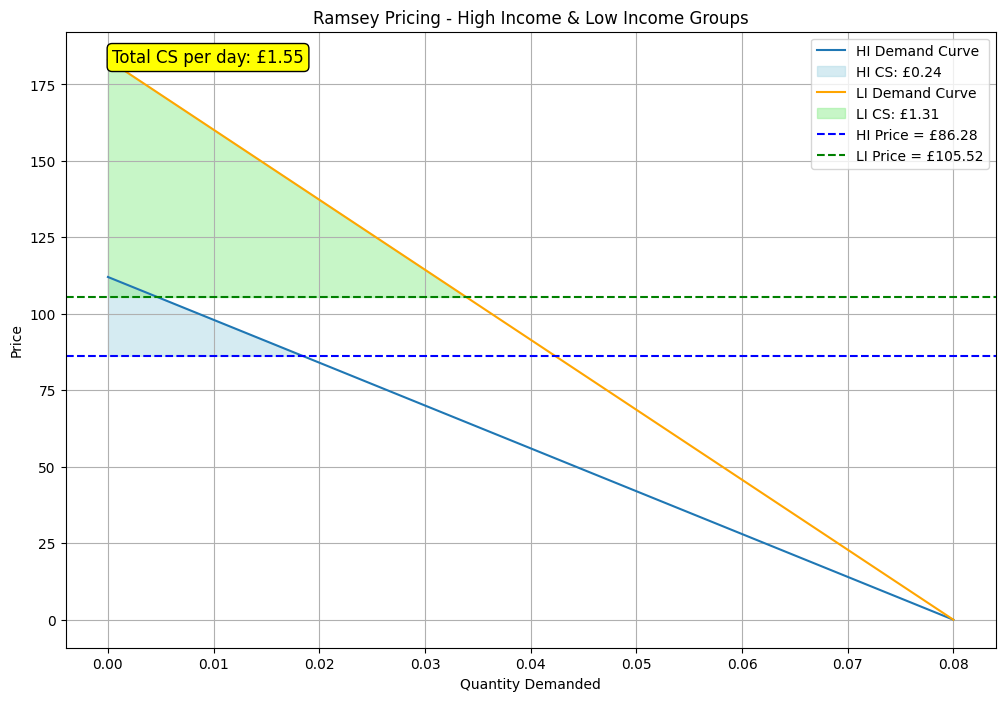

In [234]:
# Plot for both groups under Ramsey Pricing with total consumer surplus annotation
plot_combined_demand_curves_with_total_cs(A, B, p_HI_solution, C, D, p_LI_solution, 
                                          "Ramsey Pricing - High Income & Low Income Groups", 
                                          cs_HI_ramsey, cs_LI_ramsey)